# Figure 1

Start by loading some boiler plate: matplotlib, numpy, scipy, json, functools, and a convenience class.

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 16.0)
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
from scipy.optimize import bisect
import json
from functools import partial
class Foo: pass

And some more specialized dependencies:
 1. ``Slict`` provides a convenient slice-able dictionary interface
 2. ``Chest`` is an out-of-core dictionary that we'll hook directly to a globus remote using...
 3. ``glopen`` is an open-like context manager for remote globus files

In [2]:
from chest import Chest
from slict import CachedSlict
from glopen import glopen, glopen_many

Configuration for this figure.

In [3]:
config = Foo()
config.name     = "HighAspect/HA_visc/HA_visc"
config.arch_end = "alcf#dtn_mira/projects/alpha-nek"
config.frame = 91
config.lower = .25
config.upper = .75

Open a chest located on a remote globus endpoint and load a remote json configuration file.

In [4]:
c = Chest(path      = "{:s}-results".format(config.name),
          open      = partial(glopen,      endpoint=config.arch_end),
          open_many = partial(glopen_many, endpoint=config.arch_end))
sc = CachedSlict(c)
with glopen(
            "{:s}.json".format(config.name), mode='r',
            endpoint = config.arch_end,
            ) as f:
    params = json.load(f)

We want to grab all the data for the selected frame.

In [5]:
T = sc[:,'H'].keys()[config.frame]
frame = sc[T,:]
c.prefetch(frame.full_keys())

yt : [INFO     ] 2015-05-01 11:13:42,189 Parameters: current_time              = 0.0
yt : [INFO     ] 2015-05-01 11:13:42,189 Parameters: domain_dimensions         = [  448 14336     1]
yt : [INFO     ] 2015-05-01 11:13:42,190 Parameters: domain_left_edge          = [  0. -16.   0.]
yt : [INFO     ] 2015-05-01 11:13:42,190 Parameters: domain_right_edge         = [  1.  16.   1.]
yt : [INFO     ] 2015-05-01 11:13:42,191 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2015-05-01 11:13:42,230 Loading field plugins.
yt : [INFO     ] 2015-05-01 11:13:42,231 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2015-05-01 11:13:42,231 Loaded astro (15 new fields)
yt : [INFO     ] 2015-05-01 11:13:42,232 Loaded cosmology (22 new fields)
yt : [INFO     ] 2015-05-01 11:13:42,232 Loaded fluid (64 new fields)
yt : [INFO     ] 2015-05-01 11:13:42,233 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2015-05-01 11:13:42,234 Loaded geometric (112 new fields)
yt : [INFO     ] 2015-0


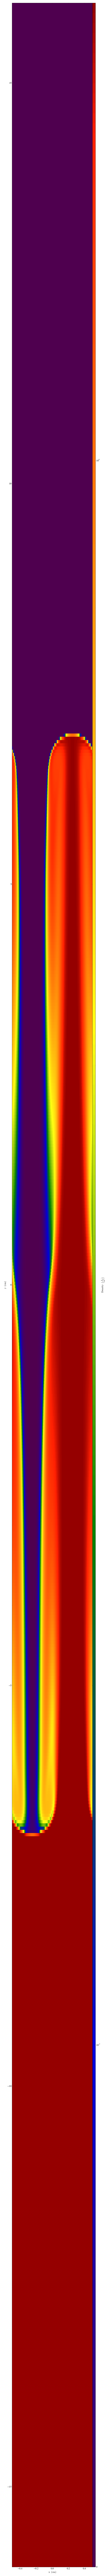

In [14]:
import yt
#test = frame['t_yz'] + 1.
test = np.tile(frame['t_yz'].transpose(),(1,1,1)).transpose() + 1.
data = dict(density = (test, "g/cm**3"))
bbox = np.array([[params['root_mesh'][1], params['extent_mesh'][1]],
                 [params['root_mesh'][2], params['extent_mesh'][2]],
                 [0., 1.]])
#bbox = np.array([[params['root_mesh'][1], params['extent_mesh'][1]],
#                 [params['root_mesh'][2], params['extent_mesh'][2]]])
ds = yt.load_uniform_grid(data, test.shape, bbox=bbox)
slc = yt.SlicePlot(ds, "z", "density")
slc.show()